# Phase1_Project

> #### Objective : To provide to Microsoft Studio information on the kinds of movies that are doing well at the box office

In [1]:
# Importing relevant libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
conn = sqlite3.connect('im.db')

In [2]:
# initial look at the different tables
# converting all the tables into a df using the dataframe constructor 

movie_basics = pd.DataFrame(pd.read_sql('SELECT * FROM movie_basics',conn))
movie_basics.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [3]:
movie_ratings = pd.DataFrame(pd.read_sql('SELECT * FROM movie_ratings',conn))
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [4]:
movie_akas = pd.DataFrame(pd.read_sql('SELECT * FROM movie_akas',conn))
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [5]:
# Getting an idea of the size of the tables

print('Shape of movie_basics table :',movie_basics.shape)
print('Shape of movie_ratings table :',movie_ratings.shape)
print('Shape of movie_akas table : ',movie_akas.shape)


Shape of movie_basics table : (146144, 6)
Shape of movie_ratings table : (73856, 3)
Shape of movie_akas table :  (331703, 8)


> **From the shapes of the tables, we can see that there is a** ***disparity in the amount of data between the tables.***
**Let's start by analyzing the movie_basics table**

In [6]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


>We can see that ***original_title, runtime_minutes and genres have missing values.***
 Getting an idea of the amount of missing data:

In [32]:
print('Number of rows missing in the original_title column :',len(movie_basics[movie_basics['original_title'].isna()]))
print('Number of rows missing in the runtime_miutes column :',len(movie_basics[movie_basics['runtime_minutes'].isna()]))
print('Number of rows missing in the genres column :',len(movie_basics[movie_basics['genres'].isna()]))


Number of rows missing in the original_title column : 21
Number of rows missing in the runtime_miutes column : 31739
Number of rows missing in the genres column : 5408


> ***Since the missing data in the 'original_title' is < 1%, we can delete those rows without suffering any consequences.***


In [33]:
# using .dropna to remove rows with NaN values in the 'original_title' columns

movie_basics.dropna(subset=['original_title'], inplace = True)

In [34]:
# check to the see the if the numbers have changed

movie_basics.info()

# can see the number of rows have reduced from 146144 to 146123

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


> ***Since we will not be examining the runtime_minutes for our analysis, we can remove the column from the dataset.***

In [35]:
movie_basics.drop('runtime_minutes', axis=1, inplace = True)
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          140734 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> ***Examining the 'genres' column:***

In [36]:
movie_basics['genres'].value_counts()

Documentary                 32185
Drama                       21486
Comedy                       9177
Horror                       4372
Comedy,Drama                 3519
                            ...  
Crime,Family,Fantasy            1
Biography,Drama,Western         1
Family,History,Mystery          1
Comedy,History,Thriller         1
Adventure,History,Sci-Fi        1
Name: genres, Length: 1085, dtype: int64

In [37]:
#creating a new column that splits the genres

movie_basics["genres_split"] = movie_basics['genres'].str.split(",")
movie_basics.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama","[Action, Crime, Drama]"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama","[Biography, Drama]"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,[Drama]
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama","[Comedy, Drama]"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"


In [38]:
# with the exolode method you have to create a new df for it to take effect

movie_basics2 = movie_basics.explode("genres_split")
movie_basics2.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Action
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Crime
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",Biography
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",Drama


> ***We can see that the values are varied(1085). Also, some movies are classified under 2-3 genres making it difficult for us to predict what the missing genres might be. 
Since the amount of missing data for the genres is also quite large i.e 5389 rows, filling in missing values with guesswork can skew the analysis in any number of ways. So the best way would be to just classify the data as 'missing'***


In [39]:
movie_basics['genres'].fillna('missing',inplace = True)

In [40]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          146123 non-null  object
 5   genres_split    140734 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.8+ MB


> ***Since the 'movie_id' is the primary key in the movie_basics table and the foreign key in the movie_ratings and movie_akas table, let's check to see if there are any duplicate values in the movie_basics table.***

In [41]:
movie_basics.duplicated(subset = ['movie_id']).value_counts()

False    146123
dtype: int64

In [85]:
movie_basics.duplicated(subset = ['primary_title']).value_counts()

False    136056
True      10067
dtype: int64

>***We have now cleaned up the movie_basics table by:***
- ***Removing null values from the original_title columns***
- ***Removing the runtime_minutes column entirely***
- ***Classifying null values in the 'genres' column as 'missing***

> ***Next up is the movie_ratings table:***

In [50]:
# Getting info about the movie_ratings table
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


> ***From the above we can see that there no null values.
But there is a difference in the number of rows: The movie_ratings table has 73,856 rows while the movie_basics has 146,123 rows indicating that not all movies listed in the movie_basics table are listed in the ratings table as well.***

In [51]:
# Checking to see if there are any missing values
movie_ratings.isna().any()

# from the results, we can see that movie_ratings table has no missing values

movie_id         False
averagerating    False
numvotes         False
dtype: bool

In [52]:
# Let's check the contents of the movie_ratings table
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


> ***Since ratings are not a focus of the analysis, let's ignore the movie_ratings table. The rating is an avergae value derived from the numvotes. Since the numvotes are not consistent, one cannot conclude that the ratings are a true reflection of audience approval/disapproval.***

>***Since the ultimate goal is to make money, the info from the movie_gross is table is paramount for the analysis.***

In [53]:
# converting the movie_gross table into a dataframe

movie_gross = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


>***Let's combine movie_basics and the movie_gross tables to get information on how much money each movie has made***

In [58]:
# using the merge method to combine the movie_basics and the movie_gross df's
# using the inner merge will give us only movie_titles that have gross amounts listed.
# any other merge method will result in a lot of redundant data

movie_gross_df = movie_basics.merge(movie_gross, how = 'inner', left_on = 'primary_title', right_on = 'title')
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,genres_split,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama","[Action, Crime, Drama]",Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance","[Adventure, Drama, Romance]",On the Road,IFC,744000.0,8000000,2012
2,tt2404548,On the Road,On the Road,2011,Drama,[Drama],On the Road,IFC,744000.0,8000000,2012
3,tt3872966,On the Road,On the Road,2013,Documentary,[Documentary],On the Road,IFC,744000.0,8000000,2012
4,tt4339118,On the Road,On the Road,2014,Drama,[Drama],On the Road,IFC,744000.0,8000000,2012


In [59]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   title           3366 non-null   object 
 7   studio          3363 non-null   object 
 8   domestic_gross  3342 non-null   float64
 9   foreign_gross   2043 non-null   object 
 10  year            3366 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 315.6+ KB


> ***To look at total_gross, need to sum domestic_gross and foreign_gross. From the above we can see that foreign_gross is listed as an object data type. Need to convert this to float64 to be able to compute the sum***

In [60]:
# removing the ',' from the string
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [61]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   title           3366 non-null   object 
 7   studio          3363 non-null   object 
 8   domestic_gross  3342 non-null   float64
 9   foreign_gross   2043 non-null   float64
 10  year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 315.6+ KB


> ***We can also see that there are some missing values in the domestic and foreign gross columns. Let's examine them:***

In [62]:
# going back to the movie_gross table

print(movie_gross_df['domestic_gross'].isna().value_counts())
print(movie_gross_df['foreign_gross'].isna().value_counts())

False    3342
True       24
Name: domestic_gross, dtype: int64
False    2043
True     1323
Name: foreign_gross, dtype: int64


> ***Getting some stats of the domestic_gross column to see if we can impute values:***

In [64]:
# we can create a function to compute the stats of any a pandas series
# we can just have the pass the series name as an argument into the function

def stats(column):
    
    mean_value = round(column.mean())
    median_value = round(column.median())
    std_dev = round(column.std())
    
    return mean_value, median_value,std_dev       

In [65]:
stat_values = stats(movie_gross_df['domestic_gross'])
stat_values

(29865597.0, 1950000.0, 65323288.0)

> ***Let's impute the median value for the missing data in the domestic_gross column and re-compute the stats to see if there is any discernible change***

In [66]:
# Imputing the median value
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross'].fillna(stat_values[1])

In [67]:
# checking to see if any missing data 
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   title           3366 non-null   object 
 7   studio          3363 non-null   object 
 8   domestic_gross  3366 non-null   float64
 9   foreign_gross   2043 non-null   float64
 10  year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 315.6+ KB


> ***We can see that the domestic_gross has no more null values***

In [68]:
# re-computing the stats
new_stat_values = stats(movie_gross_df['domestic_gross'])
new_stat_values

(29666555.0, 1950000.0, 65132297.0)

In [69]:
# Calculating percentage change:

mean_change = ((new_stat_values[0]-stat_values[0])/stat_values[0]) * 100
median_change = ((new_stat_values[1]-stat_values[1])/stat_values[1]) * 100
std_dev_change = ((new_stat_values[2]-stat_values[2])/stat_values[2]) * 100

print(mean_change, "", median_change, "", std_dev_change)

-0.6664591369126155  0.0  -0.2923781178926572


> ***We can see that there is less than 1% change if we impute the median value. So, let's keep this***

Let's examine the foreign gross column

In [73]:
movie_gross_df['foreign_gross'].isna().value_counts()

False    2043
True     1323
Name: foreign_gross, dtype: int64

> ***We can that there are 1323 empty values. Let's compute the stats again to get an idea of what we can impute.
First, we need to convert it to the float data type***

In [78]:
# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [79]:
# compute the stats 
fd_stats = stats(movie_gross_df['foreign_gross'])
fd_stats

(74551466.0, 19600000.0, 134783459.0)

> ***Note about the data : None of the stats can be considered to be accurate due to large volume of missing data ( ~ 40%). But, this is what we have to work with. We can exclude the foreign_gross data if we choose to do so later***

In [81]:
#imputing the median value
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(fd_stats[1])

In [83]:
# check the table
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   title           3366 non-null   object 
 7   studio          3363 non-null   object 
 8   domestic_gross  3366 non-null   float64
 9   foreign_gross   3366 non-null   float64
 10  year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 315.6+ KB


In [84]:
#re-compute stats
fd_new_stats = stats(movie_gross_df['foreign_gross'])
fd_new_stats

(52952895.0, 19600000.0, 108373000.0)

> ***Let's add a new column to see how much each movie grossed totally: domestic + overseas***

In [92]:
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']

In [93]:
# check to see if the total_gross column is created
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   genres_split    3326 non-null   object 
 6   title           3366 non-null   object 
 7   studio          3363 non-null   object 
 8   domestic_gross  3366 non-null   float64
 9   foreign_gross   3366 non-null   float64
 10  year            3366 non-null   int64  
 11  total_gross     3366 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 341.9+ KB


In [94]:
# check to see if there are any more missing values
movie_gross_df.isna().any()

movie_id          False
primary_title     False
original_title    False
start_year        False
genres            False
genres_split       True
title             False
studio             True
domestic_gross    False
foreign_gross     False
year              False
total_gross       False
dtype: bool

> ***Let's plot to see how much genres grossed***

In [101]:
# looking at the genres columns
movie_gross_df['genres'].value_counts()

Drama                      392
Documentary                168
Comedy,Drama,Romance       138
Comedy,Drama               137
Drama,Romance              115
                          ... 
Action,History,Thriller      1
Fantasy,Mystery,Romance      1
Comedy,Mystery,Sci-Fi        1
Action,Comedy,Western        1
History                      1
Name: genres, Length: 332, dtype: int64

In [102]:
movie_gross_df.groupby(['genres','total_gross']).sum()

start_year  domestic_gross  foreign_gross  year
genres  total_gross                                                 
Action  3302500.0          2013          2500.0   3.300000e+06  2014
        4800000.0          2010       2300000.0   2.500000e+06  2017
        4817500.0          2010         17500.0   4.800000e+06  2015
        5434000.0          2013        134000.0   5.300000e+06  2013
        19602800.0         2017          2800.0   1.960000e+07  2011
...                         ...             ...            ...   ...
missing 194600000.0        2010      75800000.0   1.188000e+08  2015
        286200000.0        2018      89100000.0   1.971000e+08  2013
        321700000.0        2018     105300000.0   2.164000e+08  2010
        807100000.0        2018     209700000.0   5.974000e+08  2017
        857600000.0        4029     713000000.0   1.002200e+09  4030

[3207 rows x 4 columns]

In [125]:
new_df = movie_gross_df.groupby(['genres','total_gross']).sum()
new_df.reset_index(inplace = True)

In [126]:
new_df.head(50)

,genres,total_gross,start_year,domestic_gross,foreign_gross,year
0,Action,3.302500e+06,2013,2500.0,3300000.0,2014
1,Action,4.800000e+06,2010,2300000.0,2500000.0,2017
2,Action,4.817500e+06,2010,17500.0,4800000.0,2015
3,Action,5.434000e+06,2013,134000.0,5300000.0,2013
4,Action,1.960280e+07,2017,2800.0,19600000.0,2011
5,Action,1.961680e+07,2013,16800.0,19600000.0,2015
6,Action,1.967190e+07,2016,71900.0,19600000.0,2016
7,Action,1.970000e+07,2012,15600000.0,4099999.0,2012
8,Action,1.971200e+07,2018,112000.0,19600000.0,2018
9,Action,1.976700e+07,2013,167000.0,19600000.0,2013


In [135]:
new_df.groupby(new_df['genres'] == 'Action').sum()

,total_gross,start_year,domestic_gross,foreign_gross,year
genres,,,,,
False,2.705160e+11,6734678,9.950986e+10,1.773142e+11,6735004
True,1.272963e+09,44303,3.477635e+08,9.252000e+08,44318


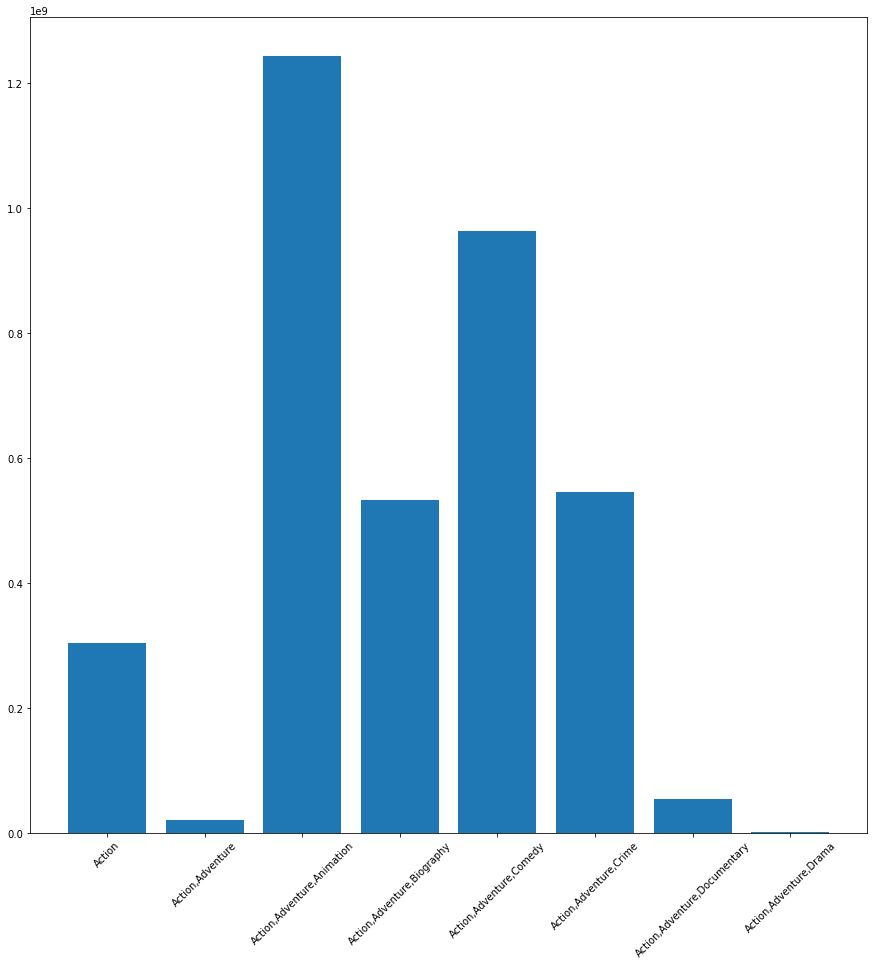

In [132]:
fig,ax = plt.subplots(figsize = (15,15))

ax.bar(x = new_df.loc[:100,'genres'], height = new_df.loc[:100,'total_gross'])
ax.tick_params(axis='x', rotation=45)
plt.show()